# p.81 연습
대출자들의 채무 상환과 관련된 데이터를 활용하여 상환 여부를 예측하기 위한 의사결정나무 분석을 실시하고 결과를 해석하시오.
* 목표변수 : BAD(범주형)
* 데이터 비율 train : test = 0.7 : 0.3
* random_state = 1234

# Step 0. 패키지 불러오기

### 나무 시각화 패키지 설치

In [1]:
# !pip install graphviz

### 경로 설정

In [2]:
# os 환경
import os
import sys
# PATH 설정
os.environ['PATH'] += os.pathsep + 'C:/Program Files (x86)/Graphviz/bin/'

### 패키지 불러오기

In [3]:
# 데이터 구성
import pandas as pd
import numpy as np
# 데이터 시각화
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
# 한글, 음수 표시
matplotlib.rc('font', family = 'Malgun Gothic')
matplotlib.rc('axes', unicode_minus = False)
# 나무 구조 시각화
import pydot
import graphviz
from sklearn import tree
from graphviz import Source
# 나무 구조 생성 및 저장
from sklearn.tree import export_graphviz
# 데이터 분리
from sklearn.model_selection import train_test_split
# RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier as RFC
# GridSearchCV
from sklearn.model_selection import GridSearchCV
# 평가함수
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
# 경고 메시지
import warnings
warnings.filterwarnings('ignore')

# Step 1. 데이터 구성하기

### 데이터 불러오기

In [4]:
df_raw = pd.read_csv('D:/Study/PoscoAcademy/2_bigdata/raw_data/HMEQ.csv')
df_raw.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1700,30548,40320.0,HomeImp,Other,9.0,0,0.0,101.466002,1.0,8,37.113614
1,1,1800,28502,43034.0,HomeImp,Other,11.0,0,0.0,88.766030,0.0,8,36.884894
2,0,2300,102370,120953.0,HomeImp,Office,2.0,0,0.0,90.992533,0.0,13,31.588503
3,1,2400,34863,47471.0,HomeImp,Mgr,12.0,0,0.0,70.491080,1.0,21,38.263601
4,0,2400,98449,117195.0,HomeImp,Office,4.0,0,0.0,93.811775,0.0,13,29.681827


### 결측치 처리

In [5]:
# 결측치 확인
df_raw.isna().sum()

BAD          0
LOAN         0
MORTDUE      0
VALUE       14
REASON       0
JOB         81
YOJ        205
DEROG        0
DELINQ      30
CLAGE       37
NINQ        56
CLNO         0
DEBTINC      0
dtype: int64

In [6]:
# JOB 변수 결측치 Other 대체
df_raw['JOB'].fillna('Other', inplace = True)
# 숫자형 변수 결측치 평균 대체
df_raw.fillna(df_raw.mean(), inplace = True)

### 더미변수 생성

In [7]:
df_raw_dummy = pd.get_dummies(df_raw)
df_raw_dummy.head()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,REASON_DebtCon,REASON_HomeImp,JOB_Mgr,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self
0,1,1700,30548,40320.0,9.0,0,0.0,101.466002,1.0,8,37.113614,0,1,0,0,1,0,0,0
1,1,1800,28502,43034.0,11.0,0,0.0,88.766030,0.0,8,36.884894,0,1,0,0,1,0,0,0
2,0,2300,102370,120953.0,2.0,0,0.0,90.992533,0.0,13,31.588503,0,1,0,1,0,0,0,0
3,1,2400,34863,47471.0,12.0,0,0.0,70.491080,1.0,21,38.263601,0,1,1,0,0,0,0,0
4,0,2400,98449,117195.0,4.0,0,0.0,93.811775,0.0,13,29.681827,0,1,0,1,0,0,0,0


### 데이터 분리

In [8]:
# 설명변수, 목표변수 데이터 구분
df_raw_x = df_raw_dummy.drop('BAD', axis = 1, inplace = False)
df_raw_y = df_raw_dummy['BAD']
# 데이터 분할
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_raw_x, df_raw_y, test_size = 0.3, random_state = 1234)
print('train data X size :', df_train_x.shape)
print('train data Y size :', df_train_y.shape)
print('test data X size :', df_test_x.shape)
print('test data Y size :', df_test_y.shape)

train data X size : (2623, 18)
train data Y size : (2623,)
test data X size : (1125, 18)
test data Y size : (1125,)


# Step 2. 랜덤 포레스트 모델 생성

### 기본 옵션으로 모델 생성

In [9]:
# 기본 모델
rfc_basic = RFC(random_state = 1234)
rfc_basic.fit(df_train_x, df_train_y)
# train/test 데이터 설명력
print('Score in train set :', rfc_basic.score(df_train_x, df_train_y).round(4))
print('Score in test set :', rfc_basic.score(df_test_x, df_test_y).round(4))

Score in train set : 1.0
Score in test set : 0.9458


* train data에 과대적합

### Hyper Parameter

##### n_estimators : 트리 수

In [11]:
# train/test 설명력 저장
train_accuracy = []
test_accuracy = []

# n_estimators
para_n_tree = [n_tree * 10 for n_tree in range(1,16)]

for v_n_estimators in para_n_tree :
    rfc = RFC(random_state = 1234,
              n_estimators = v_n_estimators)
    rfc.fit(df_train_x, df_train_y)
    train_accuracy.append(rfc.score(df_train_x, df_train_y))
    test_accuracy.append(rfc.score(df_test_x, df_test_y))
    
# 결과 저장
df_accuracy_n = pd.DataFrame()
df_accuracy_n['n_estimators'] = para_n_tree
df_accuracy_n['TrainAccuracy'] = train_accuracy
df_accuracy_n['TestAccuracy'] = test_accuracy

# 모델 설명력 확인
df_accuracy_n.round(3)

,n_estimators,TrainAccuracy,TestAccuracy
0,10,0.992,0.944
1,20,0.999,0.943
2,30,0.999,0.942
3,40,1.000,0.946
4,50,1.000,0.944
5,60,1.000,0.948
6,70,1.000,0.947
7,80,1.000,0.947
8,90,1.000,0.946
9,100,1.000,0.946


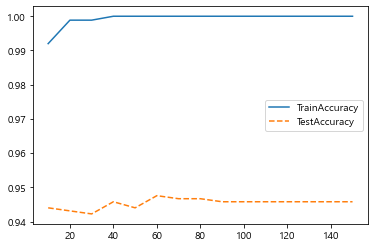

In [12]:
# 모델 설명력 그래프 확인
plt.plot(para_n_tree, train_accuracy, linestyle = '-', label = 'TrainAccuracy')
plt.plot(para_n_tree, test_accuracy, linestyle = '--', label = 'TestAccuracy')
plt.legend()

* n_estimators 증가하면 설명력은 증가
* 40, 60 중 하나 선택

##### OOB를 이용한 적정 나무 확인

Text(0.5, 0, 'n_estimators')

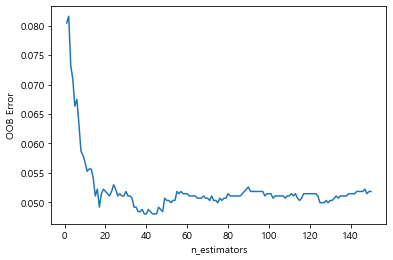

In [14]:
# error 저장 리스트
oob_error = []

# OOB
for v_n_estimators in range(1,151) :
    rfc = RFC(random_state = 1234,
              n_estimators = v_n_estimators,
              oob_score = True)
    rfc.fit(df_train_x, df_train_y)
    oob_error.append(1 - rfc.oob_score_)
    
# 그래프 확인
plt.plot(range(1,151), oob_error)
plt.ylabel('OOB Error')
plt.xlabel('n_estimators')

* 생성하는 결정 트리 수 증가에 따라 모델의 정확도는 증가하며 OOB Error는 감소
* 모델의 특성을 고려하여 100 선택

##### max_depth : 최대 깊이 변경에 따른 모델

In [15]:
# train/test 설명력 저장
train_accuracy = []
test_accuracy = []

# max_depth
para_depth = [depth for depth in range(1,11)]

for v_max_depth in para_depth :
    rfc = RFC(random_state = 1234,
              n_estimators = 100,
              max_depth = v_max_depth)
    rfc.fit(df_train_x, df_train_y)
    train_accuracy.append(rfc.score(df_train_x, df_train_y))
    test_accuracy.append(rfc.score(df_test_x, df_test_y))
    
# 결과 저장
df_accuracy_depth = pd.DataFrame()
df_accuracy_depth['Depth'] = para_depth
df_accuracy_depth['TrainAccuracy'] = train_accuracy
df_accuracy_depth['TestAccuracy'] = test_accuracy

# 모델 설명력 확인
df_accuracy_depth.round(3)

,Depth,TrainAccuracy,TestAccuracy
0,1,0.908,0.908
1,2,0.912,0.910
2,3,0.932,0.928
3,4,0.933,0.930
4,5,0.938,0.931
5,6,0.941,0.932
6,7,0.945,0.934
7,8,0.949,0.936
8,9,0.951,0.935
9,10,0.956,0.938


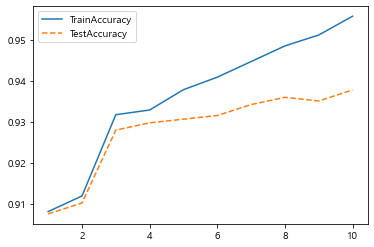

In [16]:
# 모델 설명력 그래프 확인
plt.plot(para_depth, train_accuracy, linestyle = '-', label = 'TrainAccuracy')
plt.plot(para_depth, test_accuracy, linestyle = '--', label = 'TestAccuracy')
plt.legend()

* max_depth 증가하면 설명력은 증가
* 4, 5, 6 중 하나 선택

##### min_samples_split : 분리 노드의 최소 자료 수 변경에 따른 모델

In [17]:
# train/test 설명력 저장
train_accuracy = []
test_accuracy = []

# min_samples_leaf
para_split = [n_split * 10 for n_split in range(1,11)]

for v_min_samples_split in para_split :
    rfc = RFC(random_state = 1234,
              n_estimators = 100,
              max_depth = 4,
              min_samples_split = v_min_samples_split)
    rfc.fit(df_train_x, df_train_y)
    train_accuracy.append(rfc.score(df_train_x, df_train_y))
    test_accuracy.append(rfc.score(df_test_x, df_test_y))
    
# 결과 저장
df_accuracy_split = pd.DataFrame()
df_accuracy_split['MinSamplesSplit'] = para_split
df_accuracy_split['TrainAccuracy'] = train_accuracy
df_accuracy_split['TestAccuracy'] = test_accuracy

# 모델 설명력 확인
df_accuracy_split.round(3)

,MinSamplesSplit,TrainAccuracy,TestAccuracy
0,10,0.933,0.929
1,20,0.933,0.929
2,30,0.932,0.929
3,40,0.933,0.929
4,50,0.932,0.929
5,60,0.932,0.929
6,70,0.932,0.929
7,80,0.932,0.928
8,90,0.932,0.928
9,100,0.932,0.928


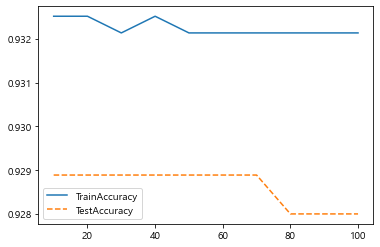

In [18]:
# 모델 설명력 그래프 확인
plt.plot(para_split, train_accuracy, linestyle = '-', label = 'TrainAccuracy')
plt.plot(para_split, test_accuracy, linestyle = '--', label = 'TestAccuracy')
plt.legend()

* min_samples_split 증가하면 설명력은 감소
* 70까지는 영향이 없으며, 80은 자료수가 크기 때문에 특정 값을 지정하지 않음

##### min_samples_leaf : 잎사귀 노드의 최소 자료 수 변경에 따른 모델

In [19]:
# train/test 설명력 저장
train_accuracy = []
test_accuracy = []

# min_samples_leaf
para_leaf = [n_leaf * 10 for n_leaf in range(1,11)]

for v_min_samples_leaf in para_leaf :
    rfc = RFC(random_state = 1234,
              n_estimators = 100,
              max_depth = 4,
              min_samples_leaf = v_min_samples_leaf)
    rfc.fit(df_train_x, df_train_y)
    train_accuracy.append(rfc.score(df_train_x, df_train_y))
    test_accuracy.append(rfc.score(df_test_x, df_test_y))
    
# 결과 저장
df_accuracy_leaf = pd.DataFrame()
df_accuracy_leaf['MinSamplesLeaf'] = para_leaf
df_accuracy_leaf['TrainAccuracy'] = train_accuracy
df_accuracy_leaf['TestAccuracy'] = test_accuracy

# 모델 설명력 확인
df_accuracy_leaf.round(3)

,MinSamplesLeaf,TrainAccuracy,TestAccuracy
0,10,0.930,0.928
1,20,0.927,0.925
2,30,0.927,0.924
3,40,0.920,0.916
4,50,0.908,0.908
5,60,0.908,0.908
6,70,0.908,0.908
7,80,0.908,0.908
8,90,0.908,0.908
9,100,0.908,0.908


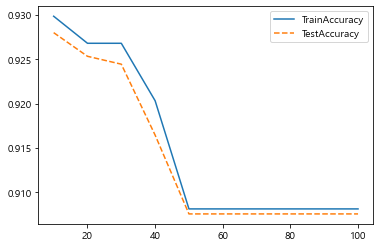

In [20]:
# 모델 설명력 그래프 확인
plt.plot(para_leaf, train_accuracy, linestyle = '-', label = 'TrainAccuracy')
plt.plot(para_leaf, test_accuracy, linestyle = '--', label = 'TestAccuracy')
plt.legend()

* min_samples_leaf 증가하면 설명력은 감소
* 10, 20, 30 중 하나 선택

##### GridSearchCV

In [29]:
estimator = RFC(random_state = 1234)
# parameter
para_grid = {'min_samples_leaf' : para_leaf,
             'max_depth' : para_depth}
# 설명력이 높은 최적 parameter 찾기
grid_rfc = GridSearchCV(estimator,
                        para_grid,
                        scoring = 'accuracy',
                        n_jobs = -1)
grid_rfc.fit(df_train_x, df_train_y)
# 결과 확인
print('best estimator model: \n{}'.format(grid_rfc.best_estimator_))
print('\nbest parameter: \n{}'.format(grid_rfc.best_params_))
print('\nbest score: \n{}'.format(grid_rfc.best_score_.round(4)))

best estimator model: 
RandomForestClassifier(max_depth=6, min_samples_leaf=10, random_state=1234)

best parameter: 
{'max_depth': 6, 'min_samples_leaf': 10}

best score: 
0.9306


# Step 3. 최종 모델 선정

### 최종 모델 생성

In [21]:
# 최종 모델
rfc_final = RFC(random_state = 1234,
                n_estimators = 100,
                max_depth = 4,
                min_samples_leaf = 20)
rfc_final.fit(df_train_x, df_train_y)
# train/test 데이터 설명력
print('Score in train set :', rfc_final.score(df_train_x, df_train_y).round(4))
print('Score in test set :', rfc_final.score(df_test_x, df_test_y).round(4))

Score in train set : 0.9268
Score in test set : 0.9253


### 최종 모델 시각화

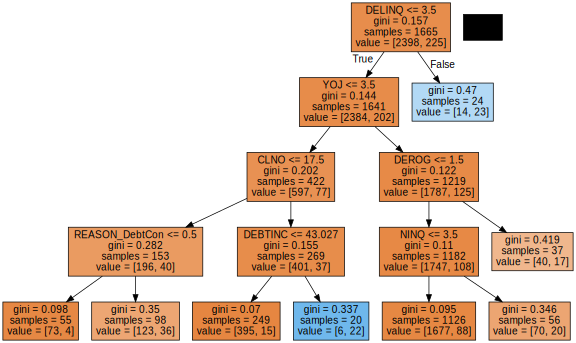

In [24]:
# 변수명 저장
v_feature_name = df_train_x.columns

# 트리 모델 시각화
export_graphviz(rfc_final.estimators_[0],
                out_file = 'rfc_final.dot',
                feature_names = v_feature_name,
                impurity = True,
                filled = True)

with open('rfc_final.dot') as f :
    dot_graph = f.read()

pdot = pydot.graph_from_dot_data(dot_graph)
pdot[0].set_graph_defaults(size = "\"8,8\"")
graph = Source(pdot[0].to_string())
graph

### 최종 모델 평가

In [27]:
# 평가
y_pred = rfc_final.predict(df_test_x)
print('Accuracy : {0:.3f}\n'.format(rfc_final.score(df_test_x,df_test_y)))
print('Confusion matrix :\n{}'.format(confusion_matrix(df_test_y, y_pred)))
# 목표변수의 빈도 불균형 : f1 score로 모델 평가
print(classification_report(df_test_y, y_pred, digits = 3))

Accuracy : 0.925

Confusion matrix :
[[1021    0]
 [  84   20]]
              precision    recall  f1-score   support

           0      0.924     1.000     0.960      1021
           1      1.000     0.192     0.323       104

    accuracy                          0.925      1125
   macro avg      0.962     0.596     0.642      1125
weighted avg      0.931     0.925     0.902      1125



# Step 4. 결론 도출

### 설명변수 중요도

In [25]:
# 설명변수 중요도 확인 및 테이블 형태 저장
df_importance = pd.DataFrame()
df_importance['Feature'] = v_feature_name
df_importance['Importance'] = rfc_final.feature_importances_
# 중요도별 정렬
df_importance.sort_values('Importance', ascending = False, inplace = True)
df_importance.round(3)

,Feature,Importance
9,DEBTINC,0.475
5,DELINQ,0.175
4,DEROG,0.066
6,CLAGE,0.061
7,NINQ,0.058
8,CLNO,0.051
0,LOAN,0.039
2,VALUE,0.027
3,YOJ,0.014
1,MORTDUE,0.013


### 설명변수 중요도 그래프

Text(0, 0.5, '변수')

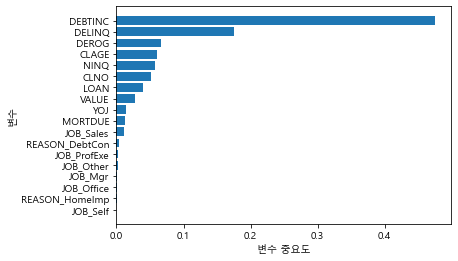

In [26]:
df_importance.sort_values('Importance', ascending = True, inplace = True)
coordinates = range(len(df_importance))
plt.barh(y = coordinates, width = df_importance['Importance'])
plt.yticks(coordinates, df_importance['Feature'])
plt.xlabel('변수 중요도')
plt.ylabel('변수')

* DEBTINC, DELINQ, DEROG 순으로 영향이 크다고 볼 수 있다.
* 계산된 변수 중요도 값이 낮거나 0이더라도 선택되는 데이터에 따라 중요도가 변경될 수 있다.